In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

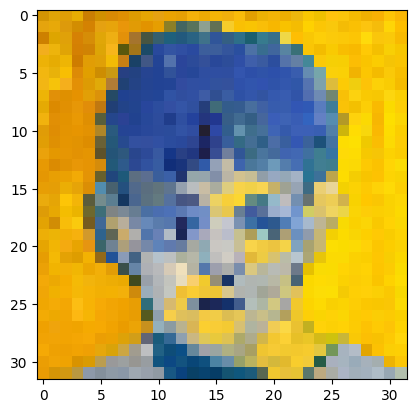

In [7]:
# load an image and resive to 32x32

image_path = 'wechatAvatars/106毛瀚燚-信科20.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (32, 32))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [13]:
# 对wechatAvatars里的所有图片进行处理
# resize成64x64
# 存储到新的文件夹里

import os

save_dir = 'images64x64'
os.makedirs(save_dir, exist_ok=True)

for file in os.listdir('wechatAvatars'):
    image_path = os.path.join('wechatAvatars', file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))

    save_path = os.path.join(save_dir, file)
    cv2.imwrite(save_path, image)


/Users/harrym/miniconda3/envs/dip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


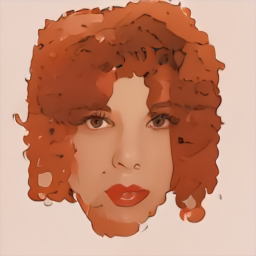

In [2]:
import torch
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('dlcvproj/ddpm-celebahq-finetuned-cartoonfaces')

pipe = pipeline.to("mps")

# Recommended if your computer has < 64 GB of RAM
pipe.enable_attention_slicing()


image = pipeline().images[0]
image

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()